In [10]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import joblib
import imodelsx.process_results
import sys
from neuro.features import qa_questions
import numpy as np
import neuro.config
import dvu
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import sasc.viz
from neuro import analyze_helper
dvu.set_style()
sys.path.append('../experiments/')
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/may15_single_question'
experiment_filename = '../experiments/04_fit_top_correlated_q.py'

# load the results in to a pandas dataframe
r = imodelsx.process_results.get_results_df(results_dir)
cols_varied = imodelsx.process_results.get_experiment_keys(
    r, experiment_filename)
print('experiment varied these params:', cols_varied)
r = imodelsx.process_results.fill_missing_args_with_default(
    r, experiment_filename)

# get the breakdown of data in these groups
r.groupby(cols_varied).size()
questions = qa_questions.get_questions(version='v3_boostexamples', full=True)


# quick overview
r['corrs_train_selected_mean'] = r['corrs_train_selected'].apply(np.nanmean)
r['corrs_test_selected_mean'] = r['corrs_test_selected'].apply(np.nanmean)
mets = [c for c in r.columns if 'corrs' in c and (
        'mean' in c or 'frac' in c)]
(
    r.groupby(cols_varied)[mets].mean()
    .style
    .background_gradient(
        cmap='viridis', axis=0)
    .format("{:.4f}")
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


experiment varied these params: ['subject']


,corrs_train_selected_mean,corrs_test_selected_mean,corrs_test_mean_baseline
subject,,,
UTS01,0.0405,0.0291,-0.0000
UTS02,0.0450,0.0600,-0.0000
UTS03,0.0455,0.0621,0.0000


### Set up data

In [38]:
dfs = []

for i, row in r.iterrows():
    df = pd.DataFrame(row['corrs_test_selected'],
                      columns=['corrs_test_selected'])
    df['subject'] = row.subject
    df['voxel_idx'] = df.index
    df['question'] = list(
        map(lambda x: questions[x % len(questions)], row.qs_selected))
    dfs.append(pd.DataFrame(df))
df = pd.concat(dfs)

# add roi info
rois_df = joblib.load(join(neuro.config.root_dir, 'qa',
                      'roi_cache', f'voxel_roi_df.pkl'))
rois_df_dict = {
    (row.subject, row.voxel_num): row.roi for i, row in rois_df.iterrows()
}
df['roi'] = df.apply(lambda x: rois_df_dict.get(
    (x.subject, x.voxel_idx), []), axis=1)

/usr/lib/python3.11/pickle.py:329: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  obj = getattr(obj, subpath)


### Format into table

In [39]:
num_rows = 20

# take the first 20 entries of each group
counts_mat = df.groupby('subject')[
    'question'].value_counts().unstack().fillna(0).T
counts_mat['Avg'] = counts_mat.mean(axis=1).round().astype(int)
counts_mat.columns = pd.MultiIndex.from_product(
    [['Voxel counts'], counts_mat.columns])

corr_mat = df.groupby(['subject', 'question'])[
    'corrs_test_selected'].mean().unstack().T
corr_mat = corr_mat.loc[counts_mat.index]
corr_mat['Avg'] = corr_mat.mean(axis=1)
corr_mat.columns = pd.MultiIndex.from_product(
    [['Test correlation'], corr_mat.columns])

roi_mat = df.explode(['roi']).groupby(['question'])[
    'roi'].value_counts().unstack().fillna(0).astype(int)
topk_rois = roi_mat.head(num_rows).sum(
).sort_values(ascending=False).index[:10]
roi_mat = roi_mat.loc[counts_mat.index, topk_rois]
roi_mat.columns = pd.MultiIndex.from_product(
    [['ROI counts (across UTS01-UTS03)'], roi_mat.columns])


full_mat = pd.concat([counts_mat, corr_mat, roi_mat], axis=1)
full_mat = full_mat.sort_values(('Voxel counts', 'Avg'), ascending=False)
# full_mat = full_mat.sort_values(('Corr', 'Avg'), ascending=False)


# Add row with index 'All' to first position in full_mat
full_mat.loc['All'] = full_mat.sum().astype(int)
full_mat = full_mat.reindex(['All'] + list(full_mat.index[:-1]))
full_mat = full_mat.head(num_rows)
full_mat.loc[['All'] * 3, [('Test correlation', f'UTS0{k}') for k in [1, 2, 3]]] = df.groupby(
    'subject')['corrs_test_selected'].mean().sort_index().values
full_mat.loc['All', ('Test correlation', 'Avg')] = df.groupby(
    'subject')['corrs_test_selected'].mean().mean()

display(
    full_mat.style.background_gradient(
        cmap='viridis', axis=0,
        subset=(full_mat.index[1:], full_mat.columns)).format(precision=2)
)

### Make flatmaps for top questions

In [ ]:
flatmaps = __import__('06_flatmaps_diffs')
vox_sizes = {
    'UTS03': 95556,
    'UTS02': 94251,
    'UTS01': 81126,
}
for subject in vox_sizes.keys():
    for i, q in tqdm(enumerate(full_mat.index[1:20])):
        vals = np.zeros(vox_sizes[subject])
        vals.fill(np.nan)
        d = df[df.subject == subject]
        d = d[d.question == q]
        vals[d.voxel_idx.values] = d.corrs_test_selected
        flatmaps._save_flatmap(
            vals, subject[2:
                          ], fname_save=f'../qa_results/single_question/{subject}_{i}_{q}.png',
            with_rois=True, cmap='BuBkRd', with_borders=True)

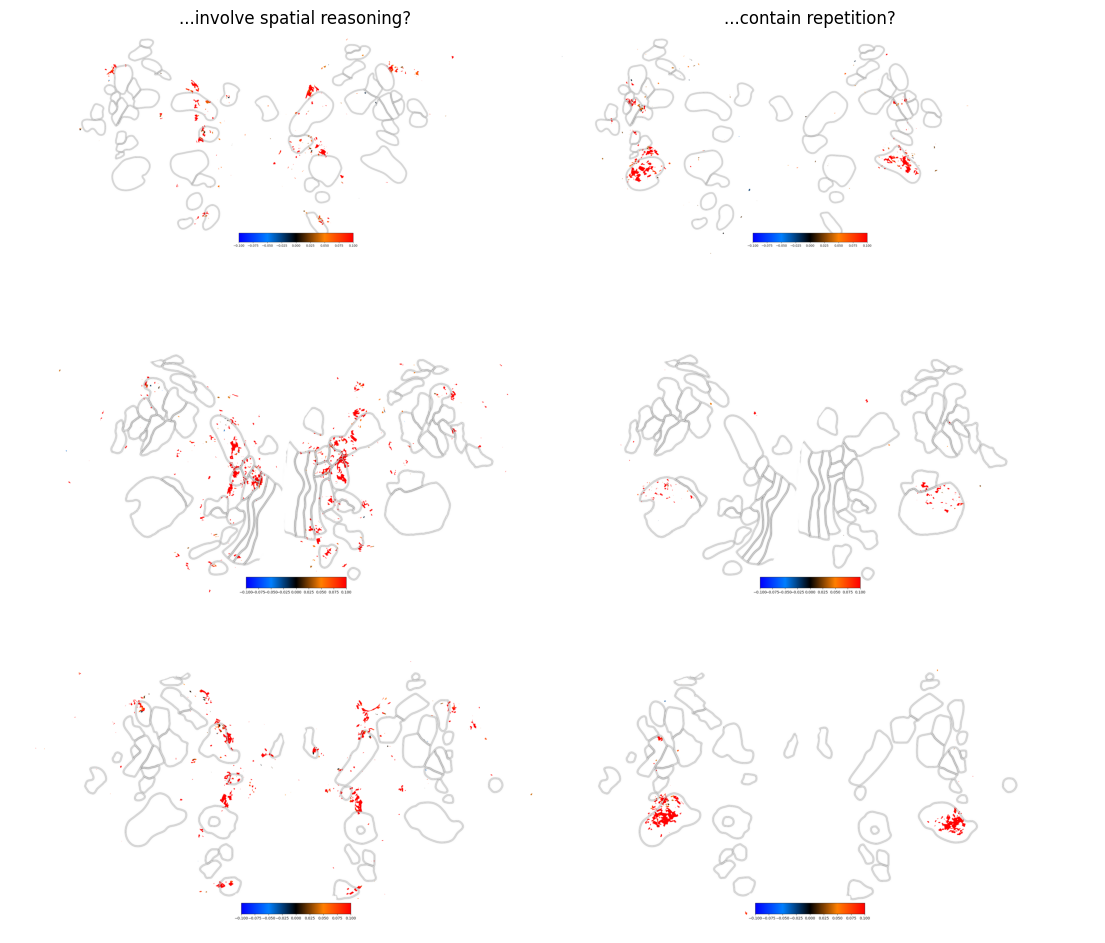

In [53]:
flatmap_dir = '../qa_results/single_question'
files = os.listdir(flatmap_dir)
files = [f for f in files if f.endswith('.png')]
keep_list = [
    'involve spatial reasoning',
    'contain repetition',
]

# filter only files that contain a substring in keep_list
files = [f for f in files if any([k in f for k in keep_list])]

files_dict = {
    subj: sorted([f for f in files if subj in f]) for subj in ['UTS01', 'UTS02', 'UTS03']
}

# plot each subject in a different row in a grid
nrows = 3
ncols = len(files) // nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 7, nrows * 4))
for i, (subj, files) in enumerate(files_dict.items()):
    for j, f in enumerate(files):
        img = Image.open(join(flatmap_dir, f))
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if i == 0:
            axs[i, j].set_title(
                f'{analyze_helper.abbrev_question(f.split("_")[2]).replace(".png", "")}')
        if j == 0:
            axs[i, j].set_ylabel(subj)
# negative horizontal space between subplots
plt.subplots_adjust(wspace=-0.1)
plt.savefig('single_question_flatmaps.png', dpi=300, bbox_inches='tight')

# Compare with 35-q model

In [2]:
data = joblib.load('results.pkl')
rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']
metric_sort = 'corrs_tune_pc_weighted_mean'

In [3]:
rr_best = rr[(rr.pc_components == 100) *
             (rr.ndelays == 8) *
             (rr.feature_space.str.contains('qa_emb')) *
             (rr.feature_selection_alpha < 0) *
             (rr.num_stories == -1) *
             (rr.qa_embedding_model == 'ensemble2')
             ]  # .sort_values(by='corrs_test_mean').iloc[-1]

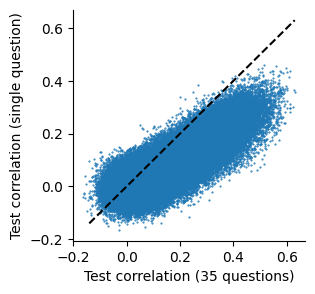

In [42]:
plt.figure(figsize=(3, 3))
for subj in ['UTS01', 'UTS02', 'UTS03']:
    # subj = 'UTS01'
    corrs_35 = rr_best[rr_best.subject ==
                       subj.replace('UT', '')]['corrs_test'].iloc[0]
    corrs_single = r[r.subject == subj]['corrs_test_selected'].iloc[0]
    plt.plot(corrs_35, corrs_single, '.', alpha=1, ms=1, color='C0')
    min_ = np.min([corrs_35, corrs_single])
    max_ = np.max([corrs_35, corrs_single])

    mask = corrs_single < 0.1
    arr = corrs_35 - corrs_single
    arr[mask] = np.nan
    sasc.viz.quickshow(arr, subject=subj, kwargs={
        # 'fig': fig})
        'with_curvature': True}, fname_save=f'single_question_vs_35_diff_{subj}.png')

plt.plot([min_, max_], [min_, max_], 'k--')
plt.xlabel('Test correlation (35 questions)')
plt.ylabel('Test correlation (single question)')
plt.savefig('single_question_vs_35.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
df

,corrs_test_selected,subject,voxel_idx,question,roi
0,0.011013,UTS03,0,Is the sentence a command?,[]
1,0.082002,UTS03,1,Is a family member mentioned?,[]
2,-0.017808,UTS03,2,Does the sentence reference a famous person or...,[]
3,0.009265,UTS03,3,Does the input discuss a natural disaster or e...,[]
4,0.003554,UTS03,4,Is the sentence a command?,[]
...,...,...,...,...,...
94246,-0.064212,UTS02,94246,Does the input express gratitude?,[M1M]
94247,-0.006577,UTS02,94247,Does the sentence involve a discussion of a fa...,[S1M]
94248,-0.022793,UTS02,94248,Does the text describe an act of kindness?,[S1M]
94249,0.036203,UTS02,94249,Is there a mention of reading or writing?,[S1M]
